## Load celebA dataset

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer
from explainers_lib.model import Model as ExplainerModel
from explainers_lib.datasets import Dataset


In [2]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)


Path to dataset files: /home/berni/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [3]:
root = path
img_dir = root + "/img_align_celeba/img_align_celeba"
attr_path = os.path.join(root, "list_attr_celeba.csv")


df = pd.read_csv(attr_path)
df = df.rename(columns=lambda s: s.strip())

# Convert to numeric labels
df["Young"] = df["Young"].apply(lambda x: 1 if x == 1 else 0)
df["Smiling"] = df["Smiling"].apply(lambda x: 1 if x == 1 else 0)

df["class"] = (
    df["Young"] * 2 + df["Smiling"]
)  # creates 0–3 target class

# Keep only first 11k (10k train + 1k test)
df = df.iloc[:11000]

train_df, test_df = train_test_split(df, test_size=1000, shuffle=True, random_state=42)

train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=42)

transform = T.Compose([
    T.Resize((128, 128)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

class Celeb4ClassDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row["class"], dtype=torch.long)
        return img, label

train_ds = Celeb4ClassDataset(train_df, img_dir, transform)
val_ds = Celeb4ClassDataset(val_df, img_dir, transform)
test_ds = Celeb4ClassDataset(test_df, img_dir, transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)


In [4]:

class_map = {
    0: "old no smile",
    1: "old smile",
    2: "young no smile",
    3: "young smile"
}


## Black-box model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)   # now feature map is 8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)  # 4 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [6]:
cnn_model_path = 'models/torch_cnn_celeba.pth'
if not os.path.exists('models'):
    os.makedirs('models')

cnn = CNN().to(device)

if os.path.exists(cnn_model_path):
    cnn.load_state_dict(torch.load(cnn_model_path, map_location=device))
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        cnn.train()
        running_loss = 0.0
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = cnn(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

        avg_loss = running_loss / len(train_dl.dataset)
        print(f'Epoch {epoch+1}, CNN Loss: {avg_loss:.4f}')

    torch.save(cnn.state_dict(), cnn_model_path)
    print(f"Model saved to {cnn_model_path}")


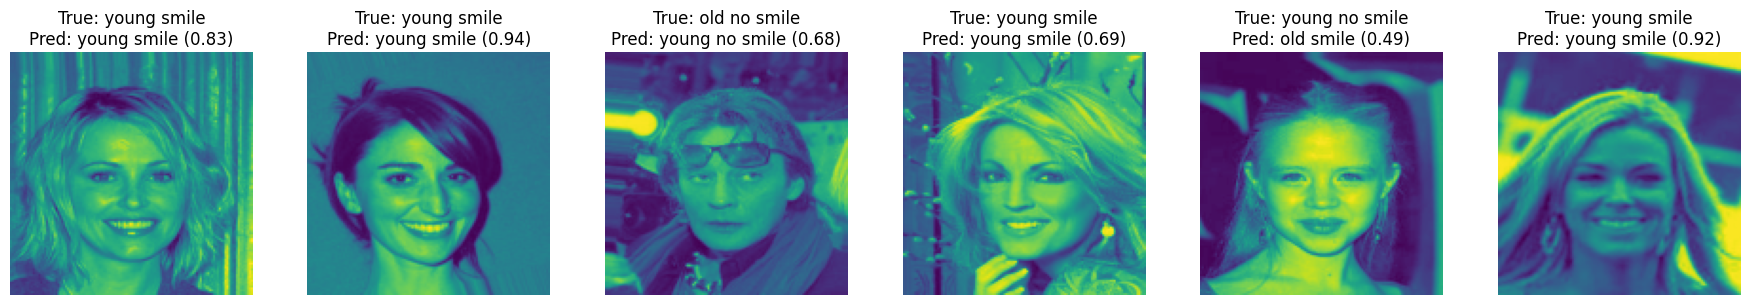

In [7]:

# Show a few sample predictions from the trained CNN on the test set
cnn.eval()

# number of samples to display
n_samples = 6

# get one batch from test loader
batch = next(iter(test_dl))
imgs_batch, labels_batch = batch
imgs = imgs_batch[:n_samples]
labels = labels_batch[:n_samples]

# forward pass
with torch.no_grad():
    imgs_device = imgs.to(device)
    outputs = cnn(imgs_device)
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1).cpu()

# plot samples with true / predicted labels and probabilities
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples * 3, 3))
if n_samples == 1:
    axes = [axes]

for i in range(n_samples):
    img = imgs[i].cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # unnormalize
    img = img.clip(0, 1)

    true_lbl = int(labels[i].item())
    pred_lbl = int(preds[i].item())
    pred_prob = float(probs[i, pred_lbl].cpu().item())

    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"True: {class_map[true_lbl]}\nPred: {class_map[pred_lbl]} ({pred_prob:.2f})")
    ax.axis("off")

plt.tight_layout()
plt.show()


### Train Autoencoder

In [8]:
# class Encoder(nn.Module):
#     def __init__(self, latent_dim=16):
#         super(Encoder, self).__init__()
#         self.latent_dim = latent_dim

#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 32, 4, stride=2, padding=1),   # 128 -> 64
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 64 -> 32
#             nn.ReLU(),
#             nn.Conv2d(64, 128, 4, stride=2, padding=1), # 32 -> 16
#             nn.ReLU(),
#             nn.Conv2d(128, 256, 4, stride=2, padding=1),# 16 -> 8
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(256*8*8, 512),
#             nn.ReLU(),
#             nn.Linear(512, latent_dim)
#         )

#     def forward(self, x):
#         return self.encoder(x)


# class Decoder(nn.Module):
#     def __init__(self, latent_dim=128):
#         super(Decoder, self).__init__()
        
#         self.decoder_fc = nn.Sequential(
#             nn.Linear(latent_dim, 256 * 8 * 8),
#             nn.LeakyReLU(0.2)
#         )

#         self.decoder_conv = nn.Sequential(
#             nn.Unflatten(1, (256, 8, 8)),
            
#             # Block 1: 8x8 -> 16x16
#             nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2),

#             # Block 2: 16x16 -> 32x32
#             nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2),

#             # Block 3: 32x32 -> 64x64
#             nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.2),

#             # Block 3: 64x64 -> 128x128
#             nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(16), # Matches the 16 output channels
#             nn.LeakyReLU(0.2),


#             # Final Output
#             nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         x = self.decoder_fc(x)
#         x = self.decoder_conv(x)
#         return x


# class Autoencoder(nn.Module):
#     def __init__(self, latent_dim=16):
#         super(Autoencoder, self).__init__()
#         self.encoder = Encoder(latent_dim)
#         self.decoder = Decoder(latent_dim)

#     def forward(self, x):
#         z = self.encoder(x)
#         out = self.decoder(z)
#         return out


In [9]:
# class GradientLoss(nn.Module):
#     """
#     Calculates the difference in edges (gradients) between the original
#     and the reconstructed image. This forces the model to generate sharp lines.
#     """
#     def forward(self, x, y):
#         # Calculate gradients in height (h) and width (w) directions
#         # We compute the difference between adjacent pixels
#         h_x = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :])
#         w_x = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1])
        
#         h_y = torch.abs(y[:, :, 1:, :] - y[:, :, :-1, :])
#         w_y = torch.abs(y[:, :, :, 1:] - y[:, :, :, :-1])
        
#         # Minimize the difference in gradients
#         return torch.mean(torch.abs(h_x - h_y)) + torch.mean(torch.abs(w_x - w_y))


In [10]:
# import torch
# import torch.nn.functional as F

# class SSIMLoss(nn.Module):
#     def __init__(self, window_size=11, size_average=True):
#         super(SSIMLoss, self).__init__()
#         self.window_size = window_size
#         self.size_average = size_average
#         self.channel = 1
#         self.window = self.create_window(window_size, self.channel)

#     def gaussian(self, window_size, sigma):
#         gauss = torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
#         return gauss/gauss.sum()

#     def create_window(self, window_size, channel):
#         _1D_window = self.gaussian(window_size, 1.5).unsqueeze(1)
#         _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
#         window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
#         return window

#     def _ssim(self, img1, img2, window, window_size, channel, size_average):
#         mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
#         mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

#         mu1_sq = mu1.pow(2)
#         mu2_sq = mu2.pow(2)
#         mu1_mu2 = mu1*mu2

#         sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
#         sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
#         sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

#         C1 = 0.01**2
#         C2 = 0.03**2

#         ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

#         if size_average:
#             return ssim_map.mean()
#         else:
#             return ssim_map.mean(1).mean(1).mean(1)

#     def forward(self, img1, img2):
#         (_, channel, _, _) = img1.size()

#         if channel == self.channel and self.window.data.type() == img1.data.type():
#             window = self.window
#         else:
#             window = self.create_window(self.window_size, channel)
            
#             if img1.is_cuda:
#                 window = window.cuda(img1.get_device())
#             window = window.type_as(img1)
            
#             self.window = window
#             self.channel = channel

#         return 1 - self._ssim(img1, img2, window, self.window_size, channel, self.size_average)

# import math


In [11]:
# class EarlyStopping:
#     def __init__(self, patience=5, min_delta=0, path='best_model.pth'):
#         """
#         Args:
#             patience (int): How many epochs to wait after last time validation loss improved.
#             min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
#             path (str): Path for the checkpoint to be saved to.
#         """
#         self.patience = patience
#         self.min_delta = min_delta
#         self.path = path
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False

#     def __call__(self, val_loss, model):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#             self.save_checkpoint(val_loss, model)
#         elif val_loss > self.best_loss - self.min_delta:
#             self.counter += 1
#             print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_loss = val_loss
#             self.save_checkpoint(val_loss, model)
#             self.counter = 0

#     def save_checkpoint(self, val_loss, model):
#         '''Saves model when validation loss decrease.'''
#         torch.save(model.state_dict(), self.path)
#         print(f'Validation loss decreased. Saving model...')


In [12]:
# ae_model_path = 'models/best_ae_celeba.pth'
# latent_dim = 32 
# autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

# criterion_l1= nn.L1Loss()
# criterion_edge = GradientLoss() 
# criterion_ssim = SSIMLoss().to(device)

# optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.1, patience=3
# )

# early_stopping = EarlyStopping(patience=15, path=ae_model_path)

# num_epochs = 500

# print("Starting training...")

# for epoch in range(num_epochs):
#     # ==========================
#     # 1. Training Phase
#     # ==========================
#     autoencoder.train()
#     train_loss = 0.0
    
#     for images, _ in train_dl:
#         images = images.to(device)
        
#         optimizer.zero_grad()
#         outputs = autoencoder(images)

#         loss_l1 = criterion_l1(outputs, images)
#         loss_ssim = 1 - criterion_ssim(outputs, images)
#         loss_edge = criterion_edge(outputs, images)
        
#         # Calculate Loss
#         loss = loss_l1 + (0.5 * loss_ssim) + (0.1 * loss_edge)        
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * images.size(0)
        
#     avg_train_loss = train_loss / len(train_dl.dataset)

#     # ==========================
#     # 2. Validation Phase (CRITICAL for Scheduling)
#     # ==========================
#     autoencoder.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for images, _ in val_dl: 
#             images = images.to(device)
#             outputs = autoencoder(images)
#             loss_l1 = criterion_l1(outputs, images)
#             loss_ssim = 1 - criterion_ssim(outputs, images)
#             loss_edge = criterion_edge(outputs, images)
            
#             # Calculate Loss
#             loss = loss_l1 + (0.5 * loss_ssim) + (0.1 * loss_edge)        
#             val_loss += loss.item() * images.size(0)
            
#     avg_val_loss = val_loss / len(val_dl.dataset)

#     print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

#     # ==========================
#     # 3. Step Scheduler & Early Stopping
#     # ==========================
    
#     scheduler.step(avg_val_loss)
    
#     early_stopping(avg_val_loss, autoencoder)
    
#     if early_stopping.early_stop:
#         print("Early stopping triggered. Stopping training.")
#         break

# autoencoder.load_state_dict(torch.load(ae_model_path))
# print("Loaded best model.")


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),   # -> 32 channels, 64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # -> 64 channels, 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # -> 128 channels, 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),# -> 256 channels, 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Flatten(),
            nn.Linear(256*8*8, latent_dim) 
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.LeakyReLU(0.2)
        )

        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (256, 8, 8)),
            
            # 8x8 -> 16x16
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # 16x16 -> 32x32
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # 32x32 -> 64x64
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # 64x64 -> 128x128
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            # Final Output: 128x128
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder_fc(x)
        x = self.decoder_conv(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        return self.decoder(self.encoder(x))
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.vgg_features = nn.Sequential(*list(vgg.features.children())[:16]).eval()
        for param in self.vgg_features.parameters():
            param.requires_grad = False
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input_img, target_img):
        if input_img.shape[1] == 1:
            input_img = input_img.repeat(1, 3, 1, 1)
            target_img = target_img.repeat(1, 3, 1, 1)
        
        input_img = (input_img + 1) / 2
        target_img = (target_img + 1) / 2
        input_img = (input_img - self.mean) / self.std
        target_img = (target_img - self.mean) / self.std
        
        return nn.functional.mse_loss(self.vgg_features(input_img), self.vgg_features(target_img))

# --- 3. Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

if os.path.exists('models/best_ae_celeba_vgg.pth'):
    autoencoder.load_state_dict(torch.load('models/best_ae_celeba_vgg.pth', map_location=device))
else:
    criterion_l1 = nn.L1Loss()
    criterion_vgg = VGGPerceptualLoss().to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

    num_epochs = 50 
    print("Starting training on", device)

    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        
        for images, _ in train_dl:
            images = images.to(device)
            optimizer.zero_grad()
            
            outputs = autoencoder(images)
            
            loss_l1 = criterion_l1(outputs, images)
            loss_vgg = criterion_vgg(outputs, images)
            
            loss = loss_l1 + (0.1 * loss_vgg) 
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dl):.4f}")

    print("Training Complete.")
    torch.save(autoencoder.state_dict(), 'models/best_ae_celeba_vgg.pth')


Starting training on cuda
Epoch 1/50, Loss: 1.3303
Epoch 2/50, Loss: 1.1673
Epoch 3/50, Loss: 1.1246
Epoch 4/50, Loss: 1.0979
Epoch 5/50, Loss: 1.0769
Epoch 6/50, Loss: 1.0622
Epoch 7/50, Loss: 1.0477
Epoch 8/50, Loss: 1.0382
Epoch 9/50, Loss: 1.0272
Epoch 10/50, Loss: 1.0189
Epoch 11/50, Loss: 1.0099
Epoch 12/50, Loss: 1.0036
Epoch 13/50, Loss: 0.9935
Epoch 14/50, Loss: 0.9890
Epoch 15/50, Loss: 0.9821
Epoch 16/50, Loss: 0.9763
Epoch 17/50, Loss: 0.9709
Epoch 18/50, Loss: 0.9640
Epoch 19/50, Loss: 0.9607
Epoch 20/50, Loss: 0.9531
Epoch 21/50, Loss: 0.9490
Epoch 22/50, Loss: 0.9426
Epoch 23/50, Loss: 0.9383
Epoch 24/50, Loss: 0.9321
Epoch 25/50, Loss: 0.9269
Epoch 26/50, Loss: 0.9237
Epoch 27/50, Loss: 0.9201
Epoch 28/50, Loss: 0.9142
Epoch 29/50, Loss: 0.9102
Epoch 30/50, Loss: 0.9072
Epoch 31/50, Loss: 0.9026
Epoch 32/50, Loss: 0.8987
Epoch 33/50, Loss: 0.8956
Epoch 34/50, Loss: 0.8916
Epoch 35/50, Loss: 0.8878
Epoch 36/50, Loss: 0.8863
Epoch 37/50, Loss: 0.8816
Epoch 38/50, Loss: 0.

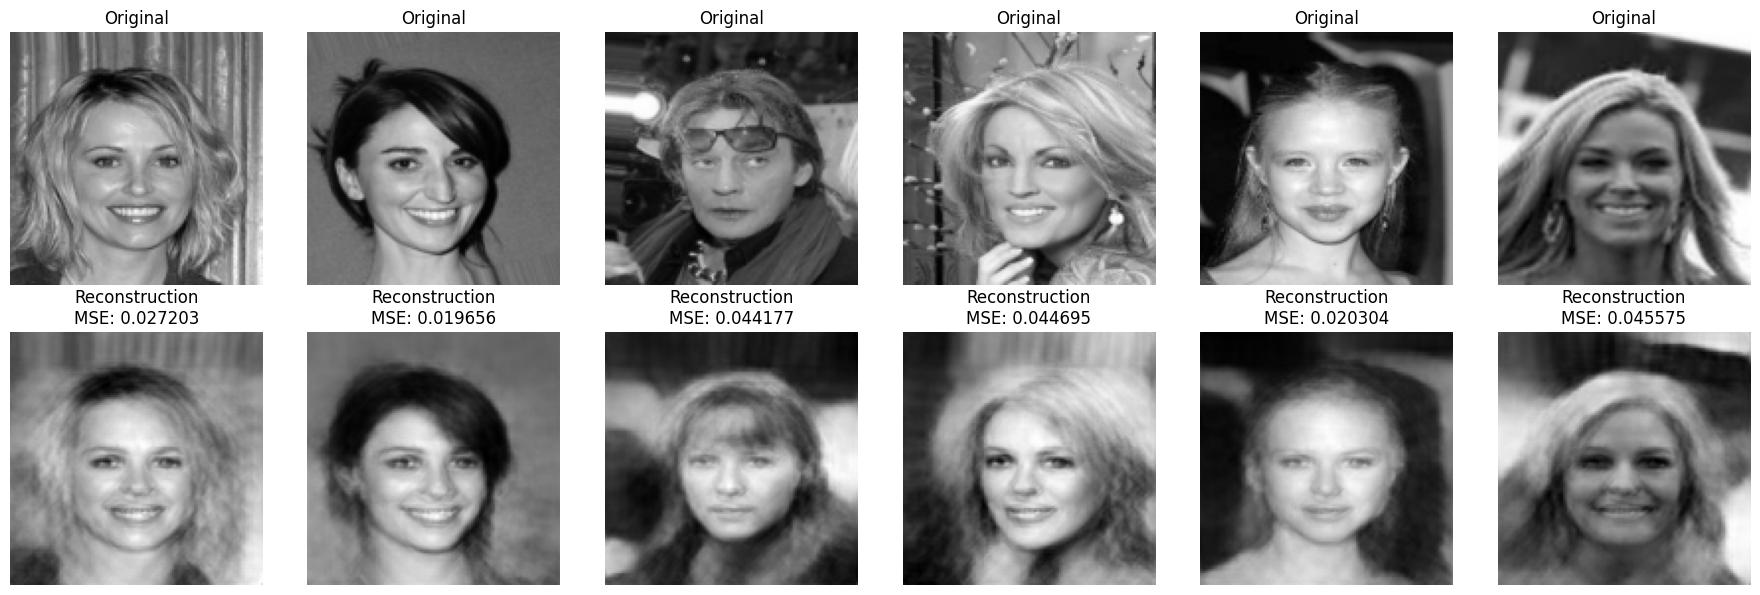

In [14]:
# Show a few samples and their reconstructions from the trained autoencoder
n = 6  # number of samples to display

batch = next(iter(test_dl))
imgs, _ = batch
imgs = imgs[:n]
imgs_device = imgs.to(device)

autoencoder.eval()
with torch.no_grad():
    recons = autoencoder(imgs_device)

# compute per-image MSE
mse_per_image = torch.mean((imgs_device - recons) ** 2, dim=[1, 2, 3]).cpu().numpy()

# prepare images for display (N, H, W, C), unnormalize from [-1,1] -> [0,1]
orig_np = imgs.cpu().permute(0, 2, 3, 1).numpy()
recon_np = recons.cpu().permute(0, 2, 3, 1).numpy()

orig_np = (orig_np * 0.5) + 0.5
recon_np = (recon_np * 0.5) + 0.5
orig_np = orig_np.clip(0, 1)
recon_np = recon_np.clip(0, 1)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, n, figsize=(n * 3, 6))
if n == 1:
    axes = axes.reshape(2, 1)

for i in range(n):
    ax_orig = axes[0, i]
    ax_rec = axes[1, i]

    ax_orig.imshow(orig_np[i], cmap='gray')
    ax_orig.set_title("Original")
    ax_orig.axis("off")

    ax_rec.imshow(recon_np[i], cmap='gray')
    ax_rec.set_title(f"Reconstruction\nMSE: {mse_per_image[i]:.6f}")
    ax_rec.axis("off")

plt.tight_layout()
plt.show()


## Generate cfs in latent space

In [15]:
class BatchedLatentWrapper(ExplainerModel):
    def __init__(self, decoder, cnn, device):
        self.decoder = decoder
        self.cnn = cnn
        self.device = device

    def predict(self, data: Dataset) -> np.ndarray:
        if isinstance(data, Dataset):
            d = data.data
        else:
            d = data
        latent_tensors = torch.tensor(d, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            decoded_images = self.decoder(latent_tensors)
            predictions = self.cnn(decoded_images)
            predicted_classes = torch.argmax(predictions, dim=1)
            
        return predicted_classes.cpu().numpy()


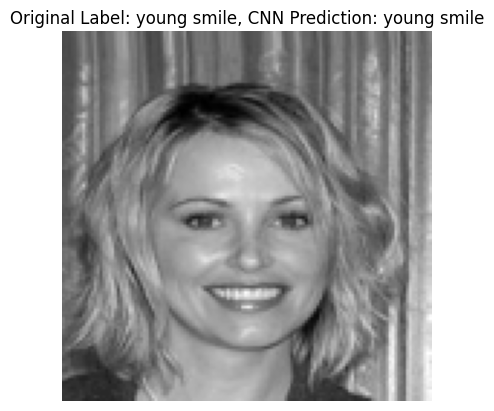

In [16]:
iter_test = iter(test_dl)
images, labels = next(iter_test)
instance_to_explain = images[0:1].to(device)
original_label = labels[0].item()

# Show original image
img = instance_to_explain.cpu().squeeze().numpy()
img = (img * 0.5) + 0.5
plt.imshow(img, cmap='gray')
plt.title(f'Original Label: {class_map[original_label]}, CNN Prediction: {class_map[torch.argmax(cnn(instance_to_explain), dim=1).item()]}')
plt.axis('off')
plt.show()


In [17]:
# encode first 10 test images into latent space and build latent_dataset
n_samples = 10

batch = next(iter(test_dl))
images_batch, labels_batch = batch
imgs = images_batch[:n_samples].to(device)
targets = labels_batch[:n_samples].cpu().tolist()

with torch.no_grad():
    latent_tensors = autoencoder.encoder(imgs)

latent_instance_np = latent_tensors.cpu().detach().numpy()
latent_dim_actual = latent_instance_np.shape[1]
feature_names = [f'l{i}' for i in range(latent_dim_actual)]

data_df = pd.DataFrame(latent_instance_np, columns=feature_names)

latent_dataset = Dataset(
    df=data_df,
    target=targets,
    features=feature_names,
    categorical_features=[],
    continuous_features=feature_names,
    immutable_features=[],
    allowable_ranges={}
)

print(f"Created latent_dataset with {len(data_df)} samples and {latent_dim_actual} latent dims")


Created latent_dataset with 10 samples and 128 latent dims


In [18]:
latent_dataset.df.head()


,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l118,l119,l120,l121,l122,l123,l124,l125,l126,l127
0,4.440971,-2.726526,0.203541,-3.255934,3.653779,5.598877,7.931581,2.160471,2.549559,0.611976,...,-0.530976,-1.679593,-4.277017,-2.447232,-3.048457,-0.336605,-3.546638,-2.018806,1.124426,0.649911
1,0.403515,-2.175616,-2.889199,-9.006616,5.007022,6.349010,11.615626,4.417105,4.265625,0.577072,...,-3.377694,0.768485,-2.712876,-9.713625,-1.947134,1.746311,-7.985756,-1.171287,4.208668,-0.219664
2,2.967039,-0.232356,0.211756,-2.580996,0.260402,6.021289,7.464700,-2.094570,4.397740,0.875751,...,4.422747,-2.640810,-0.749667,3.210446,0.037248,-1.077384,-8.364610,4.823212,-2.817511,-2.100483
3,2.419078,-0.676044,-0.429319,-0.922723,3.522432,7.216495,9.174589,0.020954,4.654163,2.014667,...,6.085023,-0.236573,0.160519,0.049314,-5.305273,-1.042711,-5.890422,-3.207738,-3.736626,-2.522792
4,3.514858,1.790153,-1.748741,-4.468379,3.264296,3.894706,5.252100,1.309990,0.544290,6.825338,...,0.932440,-5.771574,-3.055348,-3.880898,-0.286545,3.852367,-4.767321,2.161828,3.606520,3.534288


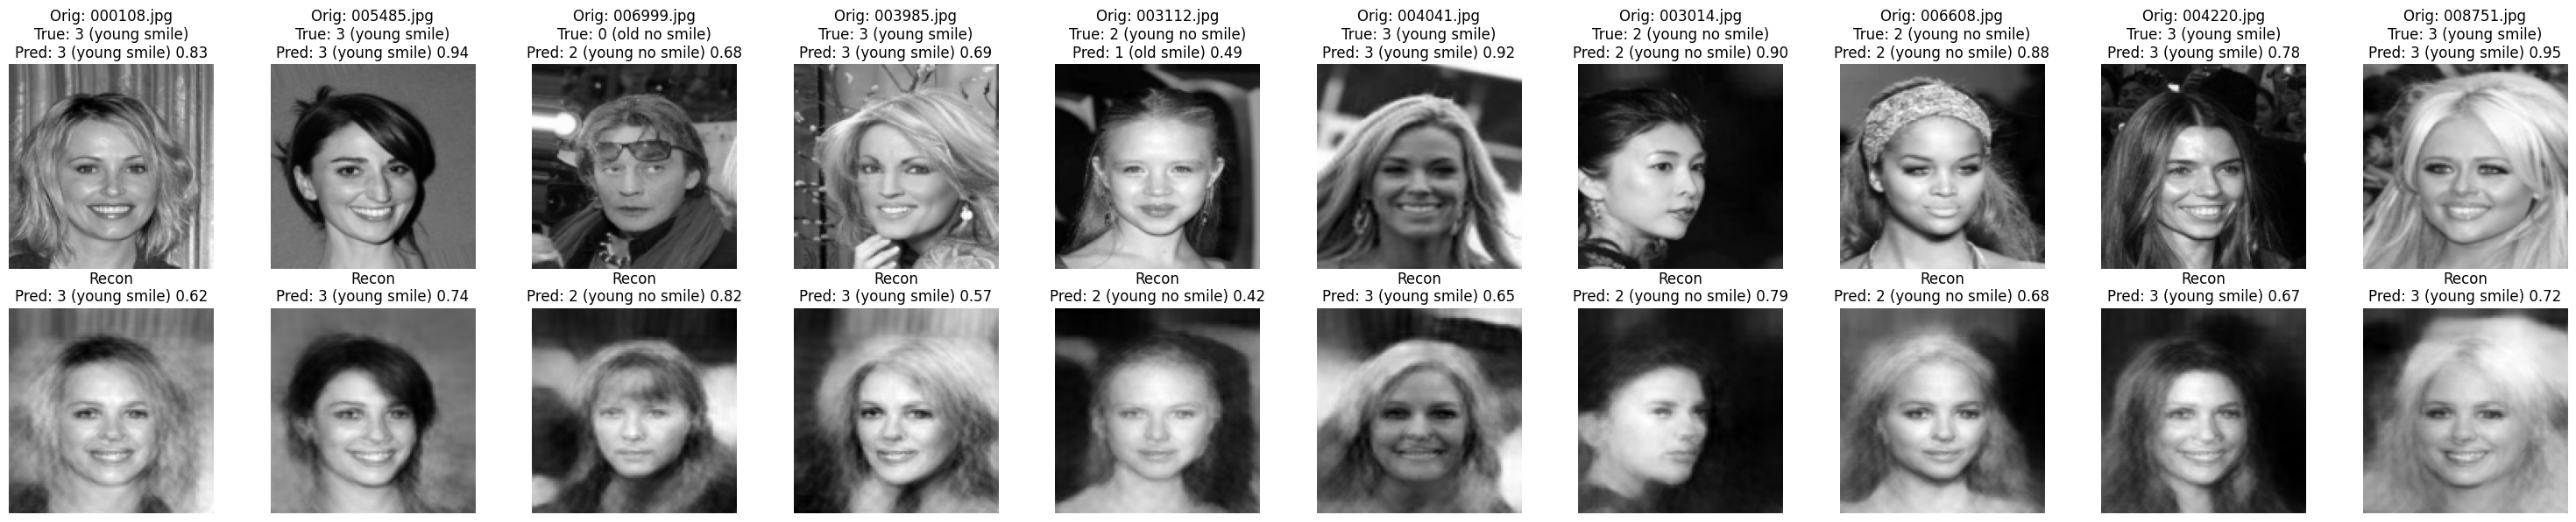

In [19]:
# Add reconstruction with autoencoder (if not already present) and plot originals/reconstructions + CNN preds
cnn.eval()
autoencoder.eval()

# ensure imgs on device for model calls
imgs_device = imgs.to(device)

with torch.no_grad():
    outputs_orig = cnn(imgs_device)
    probs_orig = torch.softmax(outputs_orig, dim=1)
    preds_orig = torch.argmax(probs_orig, dim=1).cpu().tolist()
    top_probs_orig = probs_orig.max(dim=1)[0].cpu().tolist()

# compute reconstructions with AE if missing or wrong size
if not ('recons' in globals() and isinstance(recons, torch.Tensor) and recons.size(0) == imgs.size(0)):
    with torch.no_grad():
        recons = autoencoder(imgs_device)

have_recon = isinstance(recons, torch.Tensor) and recons.size(0) == imgs.size(0)
if have_recon:
    with torch.no_grad():
        outputs_recon = cnn(recons)
        probs_recon = torch.softmax(outputs_recon, dim=1)
        preds_recon = torch.argmax(probs_recon, dim=1).cpu().tolist()
        top_probs_recon = probs_recon.max(dim=1)[0].cpu().tolist()

# DataLoader used shuffle=False so the first batch corresponds to the first rows of test_ds.df
n = imgs.size(0)
image_ids = test_ds.df.iloc[:n]['image_id'].tolist()

# prepare numpy images for display (unnormalize from [-1,1] to [0,1])
orig_np = imgs.cpu().permute(0, 2, 3, 1).numpy()
orig_np = (orig_np * 0.5) + 0.5
orig_np = orig_np.clip(0, 1)

if have_recon:
    recon_np = recons.cpu().permute(0, 2, 3, 1).numpy()
    recon_np = (recon_np * 0.5) + 0.5
    recon_np = recon_np.clip(0, 1)

import matplotlib.pyplot as plt

if have_recon:
    fig, axes = plt.subplots(2, n, figsize=(n * 3, 6))
    if n == 1:
        axes = axes.reshape(2, 1)
    for i in range(n):
        axes[0, i].imshow(orig_np[i], cmap='gray')
        axes[0, i].set_title(f"Orig: {image_ids[i]}\nTrue: {targets[i]} ({class_map[targets[i]]})\nPred: {preds_orig[i]} ({class_map[preds_orig[i]]}) {top_probs_orig[i]:.2f}")
        axes[0, i].axis("off")

        axes[1, i].imshow(recon_np[i], cmap='gray')
        axes[1, i].set_title(f"Recon\nPred: {preds_recon[i]} ({class_map[preds_recon[i]]}) {top_probs_recon[i]:.2f}")
        axes[1, i].axis("off")
else:
    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    if n == 1:
        axes = [axes]
    for i in range(n):
        axes[i].imshow(orig_np[i], cmap='gray')
        axes[i].set_title(f"{image_ids[i]}\nTrue: {targets[i]} ({class_map[targets[i]]})\nPred: {preds_orig[i]} ({class_map[preds_orig[i]]}) {top_probs_orig[i]:.2f}")
        axes[i].axis("off")

plt.tight_layout()
plt.show()


In [20]:
latent_wrapper = BatchedLatentWrapper(autoencoder.decoder, cnn, device)
explainer = GrowingSpheresExplainer(step_size=1, num_samples=2, max_radius=10000)
counterfactuals = explainer.explain(latent_wrapper, latent_dataset, y_desired=1)


10instance [00:00, 20.58instance/s]


In [21]:
counterfactuals


[Counterfactual(original_data=array([ 4.53306228e-01, -1.19845283e+00,  1.12327242e+00, -2.57763676e-02,
         5.86401641e-01,  1.59994036e-01,  2.36636281e-01,  9.16495800e-01,
         7.45503530e-02, -1.60230324e-01,  1.02943061e-02, -1.24667764e-01,
         7.63390660e-01,  9.02392268e-01, -1.26942885e+00, -1.28699327e+00,
         7.72338569e-01,  2.07571998e-01, -8.02103221e-01,  1.46384013e+00,
         2.47419849e-01,  5.91572344e-01,  4.16572988e-01, -6.61041439e-01,
        -3.32820490e-02, -3.46749842e-01, -1.29789197e+00,  1.24638259e-01,
        -3.90291721e-01,  6.07513011e-01,  1.96595579e-01, -2.31660634e-01,
        -1.74495354e-01,  8.48049104e-01,  1.40671730e+00,  2.50322402e-01,
         2.52347160e-02, -6.61601245e-01,  1.07055354e+00,  3.41227084e-01,
        -4.77893557e-03,  1.21615565e+00, -2.92109460e-01, -4.73253697e-01,
        -6.38485610e-01,  5.67568779e-01, -1.18724816e-01, -2.85069019e-01,
        -1.04789400e+00,  1.09962869e+00, -4.95303631e-01, 

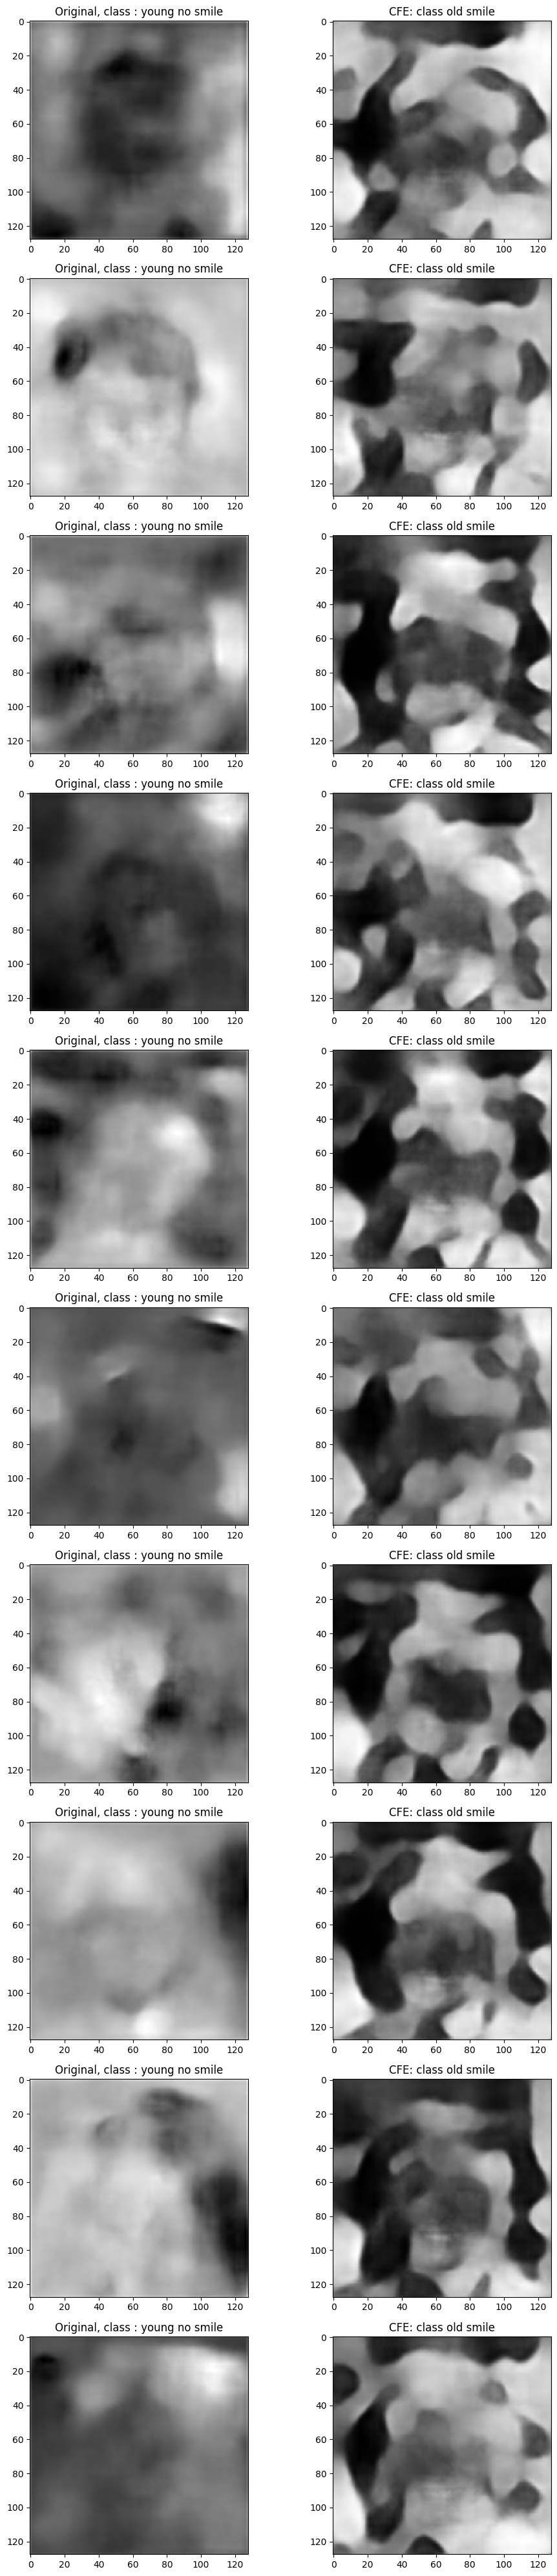

In [26]:
# Define number of rows
n = len(counterfactuals)
x = np.linspace(0, 10, 100)

plt.figure(figsize=(10, 4 * n))

for i in range(n):
    cf = counterfactuals[i]

    org_recon = autoencoder.decoder(torch.tensor(cf.original_data, dtype=torch.float32).to(device).unsqueeze(0))
    
    org_recon_np = org_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]
    
    org_recon_np = (org_recon_np * 0.5) + 0.5
    org_recon_np = org_recon_np.clip(0, 1)
    

    cfe_recon = autoencoder.decoder(torch.tensor(cf.data, dtype=torch.float32).to(device).unsqueeze(0))
    
    cfe_recon_np = cfe_recon.detach().cpu().numpy()[0][0]
    
    # cfe_recon_np = (cfe_recon_np * 0.5) + 0.5
    # cfe_recon_np = cfe_recon_np.clip(0, 1)
    

    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(org_recon_np, cmap='gray')
    plt.title(f"Original, class : {class_map[cf.original_class]}")
    
    plt.subplot(n, 2, 2 * i + 2)
    plt.imshow(cfe_recon_np, cmap='gray')
    plt.title(f"CFE: class {class_map[cf.target_class]}")

plt.tight_layout()
